In [2]:
from quchem.Hamiltonian_Generator_Functions import *
from quchem.Graph import *
### HAMILTONIAN start
Molecule = 'LiH'
geometry = None # [('H', (0., 0., 0.)), ('H', (0., 0., 0.74))]
basis = 'sto-6g'


### Get Hamiltonian
Hamilt = Hamiltonian_PySCF(Molecule,
                     run_scf=1, run_mp2=1, run_cisd=1, run_ccsd=1, run_fci=1,
                     basis=basis,
                     multiplicity=1,
                     geometry=geometry)  # normally None!
QubitHamiltonian = Hamilt.Get_Qubit_Hamiltonian(threshold=None, transformation='BK')
### HAMILTONIAN end
QubitHamiltonian

(-3.9899724181893714+0j) [] +
(0.04037460325643136+0j) [X0 X1 X2] +
(-0.003161587604205296+0j) [X0 X1 X2 X3 Y7 Y11] +
(0.0016204769263759896+0j) [X0 X1 X2 Y3 Y5] +
(0.0036508502556754363+0j) [X0 X1 X2 Z3] +
(0.0018998726581458947+0j) [X0 X1 Z2 X3 Y7 Z9 Y10 X11] +
(0.004695260540245907+0j) [X0 X1 Z2 Y3 Y4 X5] +
(-0.0012113027134835132+0j) [X0 X1 X3 X4 Y7 Y11] +
(0.0010441957704832487+0j) [X0 X1 X3 Y4 Y5 Z6 Z7] +
(0.0012113027134835132+0j) [X0 X1 X3 Y4 Z5 Y7 Z9 Z10 X11] +
(0.0025594391105536627+0j) [X0 X1 X3 Z4 Y5 Y6 Z7] +
(6.648581206854603e-05+0j) [X0 X1 X3 Z4 Z5 Y7 Z9 Y10 X11] +
(0.0012777885255520593+0j) [X0 X1 X3 Z4 Y7 Z9 Y10 X11] +
(0.0009618499558327711+0j) [X0 X1 X3 X6 Y7 Y11] +
(-0.00015670172210401827+0j) [X0 X1 X3 Z6 Y7 Z9 Y10 X11] +
(0.0009618499558327711+0j) [X0 X1 X3 Y7 X8 Y11] +
(-0.0009618499558327711+0j) [X0 X1 X3 Y7 Y8 Z10 X11] +
(-0.00015670172210402358+0j) [X0 X1 X3 Y7 Z8 Z9 Y10 X11] +
(0.0008051482337287474+0j) [X0 X1 X3 Y7 Z8 Y10 X11] +
(0.01529491011929103+0j) [X0 

The LiH ground state under JW is:

$$|\psi \rangle_{HF}^{ground} = | 1 1 1 1 \:  0 0 0 0 0 0 0 0 \rangle$$

and under BK is:

$$|\psi \rangle_{HF}^{ground} = | 1 0 1 0 0 0 0 0 0 0 0 0 \rangle$$

Use NOON to reduces this:

In [3]:
from quchem.Ansatz_Generator_Functions import *

##
NOON_spins_combined, NMO_basis = Hamilt.Get_NOON()
##
Hamilt.Get_CCSD_Amplitudes()

NOON_spins_combined

array([1.99991562e+00, 1.96764864e+00, 2.71791037e-02, 7.62575442e-05,
       2.59018655e-03, 2.59018655e-03])

In [5]:
ansatz_obj = BK_Qubit_Reduction(QubitHamiltonian,
                             Hamilt.molecule.n_electrons,
                             Hamilt.molecule.n_qubits)

# # automate:
# removed_indices, reduced_Sec_Quant_CC_ops_ia, reduced_Sec_Quant_CC_ops_ijab, reduced_theta_parameters_ia, reduced_theta_parameters_ijab =ansatz_obj.Remove_NOON_terms(
#     NOON=NOON_spins_combined,
#     occ_threshold= 1.998,
#     unocc_threshold=1e-4,
#     indices_to_remove_list_manual=None, 
#     single_cc_amplitudes=Hamilt.molecule.single_cc_amplitudes,
#     double_cc_amplitudes=Hamilt.molecule.double_cc_amplitudes,
#     singles_hamiltonian=Hamilt.singles_hamiltonian,
#     doubles_hamiltonian=Hamilt.doubles_hamiltonian,
#     tol_filter_small_terms=None)

# # manual
reduced_Sec_Quant_CC_ops_ia, reduced_Sec_Quant_CC_ops_ijab, reduced_theta_parameters_ia, reduced_theta_parameters_ijab =ansatz_obj.Remove_NOON_terms(
    NOON=NOON_spins_combined,
    indices_to_remove_list_manual=[0,1,8,9,10,11])
removed_indices =  [0,1,8,9,10,11]

In [6]:
print(print(np.around(np.diag(NOON_spins_combined), 5)))
print('removed_indices =', removed_indices)

[[1.99992e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [0.00000e+00 1.96765e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [0.00000e+00 0.00000e+00 2.71800e-02 0.00000e+00 0.00000e+00 0.00000e+00]
 [0.00000e+00 0.00000e+00 0.00000e+00 8.00000e-05 0.00000e+00 0.00000e+00]
 [0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 2.59000e-03 0.00000e+00]
 [0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 2.59000e-03]]
None
removed_indices = [0, 1, 8, 9, 10, 11]


LOOK at PHYS. REV. X, **8**, 031022 (2018)

Due to NOON:
- indices 0,1 assumed to ALWAYS be filled
- indices 8,9 and 10,11 ALWAYS unfilled! <--- decision



# Therefore Simplify Hamiltonian

The LiH ground state under JW is:

$$|\psi \rangle_{HF}^{ground} = | 1 1 1 1 \:  0 0 0 0 0 0 0 0 \rangle$$

and under BK is:

$$|\psi \rangle_{HF}^{ground} = | 1 0 1 0 0 0 0 0 0 0 0 0 \rangle$$


we have **fixed occupations** of indices [0,1,8,9,10,11]

- therefore can remove these terms from the Hamiltonian!

In [7]:
reduced_Qubit_Hamiltonian = ansatz_obj.Remove_indices_from_Hamiltonian(removed_indices)
print('Hamiltonian size reduced: {} --> {}'.format(len(list(QubitHamiltonian)), len(list(reduced_Qubit_Hamiltonian))))

Hamiltonian size reduced: 631 --> 239


In [8]:
qubit_re_label_dict, reduced_RE_LABELLED_Qubit_Hamiltonian = ansatz_obj.Re_label_Hamiltonian(reduced_Qubit_Hamiltonian)
reduced_RE_LABELLED_Qubit_Hamiltonian

(-7.264831837971695+0j) [] +
(0.10945352587995119+0j) [X0] +
(0.009344683608051279+0j) [X0 X1 X2 X3] +
(-0.001062048701645766+0j) [X0 X1 X2 Y5] +
(0.0016204769263759894+0j) [X0 X1 Y2 X3] +
(-0.00027634696897363924+0j) [X0 X1 Y2 Y3 Z4 Z5] +
(0.001062048701645766+0j) [X0 X1 Y2 Z3 Y5] +
(-0.0016204769263759896+0j) [X0 X1 Z2 X3] +
(0.004836443728006887+0j) [X0 X1 Z2 Y3 Y4 Z5] +
(-0.0036483490336049916+0j) [X0 X1 Z2 Z3 Y5] +
(-0.0025863003319592254+0j) [X0 X1 Z2 Y5] +
(0.004075918085156346+0j) [X0 X1 X4 Y5] +
(-0.009750569335355392+0j) [X0 X1 Z4 Y5] +
(-0.023380157572584305+0j) [X0 X1 Y5] +
(-0.0016204769263759894+0j) [X0 Y1 X2 X3] +
(0.00032184554262142573+0j) [X0 Y1 X2 Y3] +
(0.004739070747209701+0j) [X0 Y1 Y2 X3] +
(0.004560096759033248+0j) [X0 Y1 Y2 X3 Z4] +
(-0.005863061579432814+0j) [X0 Y1 Z2 X3] +
(0.00024156424816656683+0j) [X0 Y1 Y3] +
(-0.004836443728006887+0j) [X0 Y1 Y3 X4] +
(-0.004075918085156346+0j) [X0 Y1 Z3 Y4 X5] +
(-0.005674651250199046+0j) [X0 Y1 Z3 Z4 X5] +
(0.0405489400

In [9]:
new_Molecular_H_MATRIX = Hamilt.Get_sparse_Qubit_Hamiltonian_matrix(reduced_RE_LABELLED_Qubit_Hamiltonian)


from scipy.sparse.linalg import eigs
eig_values, eig_vectors = eigs(new_Molecular_H_MATRIX)
new_FCI_Energy = min(eig_values)


print('new_FCI = ', new_FCI_Energy, 'VS old FCI:', Hamilt.molecule.fci_energy)

new_FCI =  (-7.940677175840132+1.806040540595562e-16j) VS old FCI: -7.875652564927912


## Looking at Ansatz

In [10]:
ia_terms, ijab_terms, ia_theta, ijab_theta = ansatz_obj.Get_ia_and_ijab_terms()
print('REDUCTION')
print('ia_terms', len(ia_terms), 'TO', len(reduced_Sec_Quant_CC_ops_ia))
print('ijab_terms', len(ijab_terms), 'TO', len(reduced_Sec_Quant_CC_ops_ijab))

REDUCTION
ia_terms 16 TO 4
ijab_terms 42 TO 3


In [11]:
Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab = ansatz_obj.UCCSD_single_trotter_step(reduced_Sec_Quant_CC_ops_ia,
                                                                                                                    reduced_Sec_Quant_CC_ops_ijab,
                                                                                                                    transformation='BK')

# # NO reduction!
# Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab = ansatz_obj.UCCSD_single_trotter_step(ia_terms,
#                                                                                                                     ijab_terms,
#                                                                                                                     transformation='BK')


In [12]:
reduced_CC_ijab = ansatz_obj.Remove_indices_from_CC_qubit_operators(Qubit_Op_list_Second_Quant_CC_Ops_ijab, removed_indices)
len(reduced_CC_ijab)

3

In [13]:
reduced_RE_LABELLED_CC_ijab = ansatz_obj.Re_label_CC_qubit_operators( qubit_re_label_dict, 
                                                                   reduced_CC_ijab)
reduced_RE_LABELLED_CC_ijab

[0.125j [X0 Z1 Y2] +
 0.125j [X0 Z1 Y2 Z3] +
 0.125j [X0 Y2] +
 0.125j [X0 Y2 Z3] +
 -0.125j [Y0 Z1 X2] +
 -0.125j [Y0 Z1 X2 Z3] +
 -0.125j [Y0 X2] +
 -0.125j [Y0 X2 Z3],
 0.125j [X0 Z1 X2 Y3 Z4] +
 0.125j [X0 Z1 Y2 X3 Z5] +
 0.125j [X0 X2 Y3 Z4] +
 0.125j [X0 Y2 X3 Z5] +
 -0.125j [Y0 Z1 X2 X3 Z5] +
 0.125j [Y0 Z1 Y2 Y3 Z4] +
 -0.125j [Y0 X2 X3 Z5] +
 0.125j [Y0 Y2 Y3 Z4],
 0.125j [X0 Z1 Z3 Y4 Z5] +
 0.125j [X0 Z1 Y4] +
 0.125j [X0 Z3 Y4 Z5] +
 0.125j [X0 Y4] +
 -0.125j [Y0 Z1 Z3 X4 Z5] +
 -0.125j [Y0 Z1 X4] +
 -0.125j [Y0 Z3 X4 Z5] +
 -0.125j [Y0 X4]]

In [14]:
reduced_CC_ia = ansatz_obj.Remove_indices_from_CC_qubit_operators(Qubit_Op_list_Second_Quant_CC_Ops_ia, removed_indices)

reduced_RE_LABELLED_CC_ia = ansatz_obj.Re_label_CC_qubit_operators( qubit_re_label_dict, 
                                                                   reduced_CC_ia)
reduced_RE_LABELLED_CC_ia

[0.5j [X0 Y1 X2] +
 0.5j [Y0 Y1 Y2],
 0.5j [X0 Y1 Z3 X4] +
 0.5j [Y0 Y1 Z3 Y4],
 0.5j [Z0 Y1 Z2 X3] +
 -0.5j [X1 Y3],
 0.5j [Z0 Y1 Z3 Z4] +
 -0.5j [Y1 Z5]]

## HF input state

In [15]:
print('old input = ', ansatz_obj.Get_BK_HF_state_in_OCC_basis())
print('BUT following indices removed:', removed_indices)
ansatz_obj.New_BK_HF_state(removed_indices)

old input =  [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
BUT following indices removed: [0, 1, 8, 9, 10, 11]


array([1., 0., 0., 0., 0., 0.])

# Ansatz

look at: From PHYS. REV. X, **8**, 031022 (2018)

can make a further reduction!

In [16]:
import random
theta_ia_random_input = [random.uniform(0, 2*np.pi) for _ in range(len(reduced_RE_LABELLED_CC_ia))]
theta_ijab_random_input = [random.uniform(0, 2*np.pi) for _ in range(len(reduced_RE_LABELLED_CC_ijab))]

In [26]:
input_state = ansatz_obj.New_BK_HF_state(removed_indices)
print('input_state =', input_state)

UCCSD_ansatz_Q_Circ_obj = Ansatz_Circuit(input_state,
                                     reduced_RE_LABELLED_CC_ia, 
                                     reduced_RE_LABELLED_CC_ijab)

ansatz_cirq_circuit =UCCSD_ansatz_Q_Circ_obj.Get_Full_HF_UCCSD_QC(Theta_param_list_ia=theta_ia_random_input, 
                                         Theta_param_list_ijab=theta_ijab_random_input,
                                         ia_first=True)
ansatz_cirq_circuit

input_state = [1. 0. 0. 0. 0. 0.]


┌─────────┐   ┌────────────┐                ┌──────────┐
0: ───X───H──────────@─────────────────────────@───H───────────Rx(0.5π)───@─────────────────────────@───────────Rx(-0.5π)───H──────────@─────────────────────────────────@──────────H───────────Rx(0.5π)───@─────────────────────────────────────────@───Rx(-0.5π)──────────────@─────────────────────────────────@──────────────────────────────────────────────────────────────────────@─────────────────────────────────@───H────────────────────@─────────────────────@─────────────H─────────────H───────────@─────────────────────────@───────────H───Rx(0.5π)───@────────────────@───Rx(-0.5π)───Rx(0.5π)───@────────────────────────@───Rx(-0.5π)───Rx(0.5π)───@────────────────────────@───Rx(-0.5π)───Rx(0.5π)───@────────────────────────────────@───Rx(-0.5π)───H───@─────────────────────────@───H───────────H──────────@────────────────────────────────────────@───────────H───H───@─────────────────────────────────@───────────H──────────H───@─────────────────────────────────────────────────@──────────H──────────Rx(0.5π)───@─────────────────────────────────@───────────Rx(-0.5π)───Rx(0.5π)───@────────────────────────────────────────────────────────@───────────Rx(-0.5π)───Rx(0.5π)───@────────────────────────────────────────@───Rx(-0.5π)───Rx(0.5π)───@────────────────────────────────@───Rx(-0.5π)───H──────────@─────────────────────────────────────────@───────────H──────────H───@─────────────────────────────────@───H───────────H───@────────────────@───H───────────H──────────@────────────────────────@───────────H───Rx(0.5π)───@───────────────@───Rx(-0.5π)───Rx(0.5π)───@───────────────────────@───Rx(-0.5π)───Rx(0.5π)───@───────────────────────────────────────@───Rx(-0.5π)───Rx(0.5π)───@───────────────────────────────@───Rx(-0.5π)───H───@────────────────────────────────────────────────@──────────H───H───@────────────────────────────────@───────────H───
                     │                         │                          │                         │                                  │                                 │                                 │                                         │                          │                                 │                                                                      │                                 │                        │                     │                                       │                         │                          │                │                          │                        │                          │                        │                          │                                │                   │                         │                          │                                        │                   │                                 │                          │                                                 │                                │                                 │                                  │                                                        │                                  │                                        │                          │                                │                          │                                         │                          │                                 │                   │                │                          │                        │                          │               │                          │                       │                          │                                       │                          │                               │                   │                                                │                  │                                │
1: ───I───Rx(0.5π)───X───@─────────────────@───X───Rx(-0.5π)───Rx(0.5π)───X───@─────────────────@───X───────────Rx(-0.5π)───Rx(0.5π)───X───@─────────────────────────@───X──────────Rx(-0.5π)───Rx(0.5π)───X───@─────────────────────────@───────────X───Rx(-0.5π)──

# Running Example

In [18]:
Hamiltonian_graph_obj = Openfermion_Hamiltonian_Graph(reduced_RE_LABELLED_Qubit_Hamiltonian)

commutativity_flag = 'AC' ## <- defines relationship between sets!!!
plot_graph = False
Graph_colouring_strategy='largest_first'
anti_commuting_sets = Hamiltonian_graph_obj.Get_Clique_Cover_as_QubitOp(commutativity_flag, Graph_colouring_strategy=Graph_colouring_strategy, plot_graph=plot_graph)
anti_commuting_sets

Building Graph Edges: 100%|##########| 239/239 [00:02<00:00, 99.33it/s] 


{0: [(0.07828114149315556+0j) [Z1 Z3 Z5]],
 1: [(-7.264831837971695+0j) []],
 2: [(-0.1443201912269888+0j) [Z1 Z3 Z4 Z5],
  (0.005610346244611377+0j) [Y4],
  (0.010671449192243533+0j) [Z1 Z3 X4 Z5]],
 3: [(-0.1443201912269888+0j) [Z4],
  (0.005610346244611377+0j) [Z1 Z3 Y4 Z5],
  (0.010671449192243533+0j) [X4]],
 4: [(0.01754878392503334+0j) [Z0],
  (0.10945352587995119+0j) [X0],
  (0.004931982511595049+0j) [Y0]],
 5: [(-0.134317198775724+0j) [Z2 Z3],
  (0.004739070747209696+0j) [X1 Z2 X3],
  (0.011871946723160987+0j) [Y2],
  (0.022273980559951834+0j) [X2],
  (0.0025594391105536627+0j) [X1 Z2 Y3 X4 Z5],
  (0.032871208180024855+0j) [Z1 Z2 X3 Y5],
  (0.0025594391105536627+0j) [X1 Z2 Y3 Y4 Z5],
  (-0.003603634881036912+0j) [X1 Z2 Y3 Z4 Z5]],
 6: [(-0.13431719877572407+0j) [Z2],
  (0.011871946723160987+0j) [Y2 Z3],
  (0.005863061579432814+0j) [X1 Y2 X3],
  (0.004739070747209701+0j) [X0 Y1 Y2 X3],
  (-0.002688933646887501+0j) [Z1 Y2 X3 Y5],
  (0.004836443728006888+0j) [Z0 X1 Y2 Y3 X4 Z5],
 

In [19]:
from quchem.LCU_method import *

In [20]:
N_QUBITS = Hamilt.molecule.n_qubits - len(removed_indices)

def GIVE_ENERGY_lin_alg(theta_ia_ijab):
    
    theta_ia= theta_ia_ijab[:(len(reduced_theta_parameters_ia))]
    theta_ijab=theta_ia_ijab[(len(reduced_theta_parameters_ia)):]
   
    ansatz_cirq_circuit =UCCSD_ansatz_Q_Circ_obj.Get_Full_HF_UCCSD_QC(
                                        Theta_param_list_ia=theta_ia, 
                                         Theta_param_list_ijab=theta_ijab,
                                         ia_first=True)

    VQE_exp_LCU_lin_alg = VQE_Experiment_LCU_UP_lin_alg(anti_commuting_sets,
                 ansatz_cirq_circuit,
                 N_QUBITS,                     # <--- NOTE THIS
                 N_indices_dict=None) 
    
    return VQE_exp_LCU_lin_alg.Calc_Energy().real

In [21]:
import random

theta_ia_random_input = [random.uniform(0, 2*np.pi) for _ in range(len(reduced_theta_parameters_ia))]
theta_ijab_random_input = [random.uniform(0, 2*np.pi) for _ in range(len(reduced_theta_parameters_ijab))]

theta_combined_random_input = [*theta_ia_random_input, *theta_ijab_random_input]

GIVE_ENERGY_lin_alg(theta_combined_random_input)

-8.92499723747039

## Simulating

In [22]:
theta_combined_random_input

[3.5971748950678712,
 3.295584251731401,
 4.558337735918461,
 3.5388104668571296,
 1.4625345490826567,
 2.149499097493241,
 2.136622122964884]

In [23]:
def calc_gradient_ADAM(theta_ia_theta_jab_list):
    
    grad_list=[]
    
    for index, theta in enumerate(theta_ia_theta_jab_list):
        
        new_theta_list = theta_ia_theta_jab_list.copy()
        new_theta_list[index] = theta + np.pi/4
        
        Obs_PLUS = GIVE_ENERGY_lin_alg(new_theta_list)
               
        
        new_theta_list[index] = theta - np.pi/4
        Obs_MINUS = GIVE_ENERGY_lin_alg(new_theta_list)
        
        gradient = Obs_PLUS - Obs_MINUS
        
        grad_list.append(gradient)
        

    return np.array(grad_list)

In [24]:
### optimizer
from quchem.Scipy_Optimizer import _minimize_Adam, Optimizer

0: Input_to_Funct: [3.4971749  3.19558425 4.65833774 3.43881047 1.56253455 2.24949909
 2.23662209]: Output: -9.172295521053762
1: Input_to_Funct: [3.39848757 3.09737913 4.71628479 3.35402563 1.63012374 2.31799744
 2.29254201]: Output: -9.096834252711366
2: Input_to_Funct: [3.30084632 3.04701654 4.69148608 3.28943346 1.6833894  2.37144703
 2.33799544]: Output: -9.164637549151879
3: Input_to_Funct: [3.20508222 3.04919397 4.63832079 3.23288208 1.71399078 2.41039076
 2.34994962]: Output: -9.278394277590563
4: Input_to_Funct: [3.11631699 3.07631714 4.57545291 3.17746204 1.68714861 2.41962922
 2.30335575]: Output: -9.382325109980503
5: Input_to_Funct: [3.04538815 3.11406588 4.51397565 3.12828438 1.63006665 2.39455905
 2.2395279 ]: Output: -9.504610122265495
6: Input_to_Funct: [3.00049224 3.15427349 4.46210987 3.11562299 1.561155   2.3479246
 2.16529773]: Output: -9.844902586337335
7: Input_to_Funct: [2.98055257 3.19216995 4.43085398 3.15039454 1.4846876  2.31745794
 2.11833678]: Output: -11.

64: Input_to_Funct: [3.56997757 3.18030704 4.23576596 1.85275665 1.69256964 3.63294923
 1.33024561]: Output: -11.176227349277461
65: Input_to_Funct: [3.54951159 3.21345135 4.21827045 1.86535855 1.7008953  3.62781106
 1.31561879]: Output: -11.143023441190191
66: Input_to_Funct: [3.53405052 3.23927137 4.19957207 1.88503858 1.70799182 3.62297653
 1.302124  ]: Output: -11.158233599789588
67: Input_to_Funct: [3.52457475 3.25372417 4.1799126  1.91165805 1.71402041 3.61847016
 1.28959755]: Output: -11.256433723403706
68: Input_to_Funct: [3.52186792 3.25257112 4.15953879 1.94445229 1.71911536 3.61434123
 1.27789989]: Output: -11.462498484231082
69: Input_to_Funct: [3.52649399 3.23231961 4.13869837 1.98194311 1.72336352 3.61067245
 1.26693734]: Output: -11.765649782034995
70: Input_to_Funct: [3.53880912 3.19090864 4.11765563 2.02236928 1.72675184 3.60755584
 1.25668617]: Output: -12.067201413937925
71: Input_to_Funct: [3.5590062  3.12914622 4.09673206 2.06424009 1.72906503 3.60501218
 1.2471988

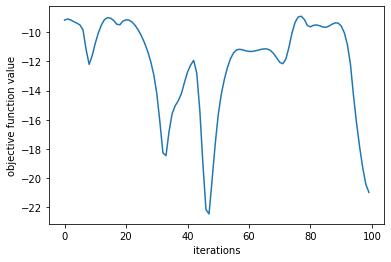

In [25]:
custom_optimizer_DICT = {'learning_rate': 0.1, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-8,
                           'delta': 1e-8, 'maxfev': 15000}

GG = Optimizer(GIVE_ENERGY_lin_alg,
                   theta_combined_random_input,
                   args=(),
                   method=_minimize_Adam,
                   jac=calc_gradient_ADAM,
                   hess=None,
                   hessp=None,
                      bounds=None,
                   constraints=None,
                   tol=1e-20, 
                   display_convergence_message=True,
                   display_steps=True, 
                   custom_optimizer_DICT=custom_optimizer_DICT)
GG.get_env(100)
GG.plot_convergence()
plt.show()

In [ ]:
# Nelder-Mead

GG = Optimizer(GIVE_ENERGY_lin_alg,
                   theta_combined_random_input,
                   args=(),
                   method='Nelder-Mead',
                   jac=None,
                   hess=None,
                   hessp=None,
                      bounds=None,
                   constraints=None,
                   display_convergence_message=True,
                   display_steps=True)

GG.get_env(50)
GG.plot_convergence()
plt.show()

In [ ]:
# # finite difference

# custom_optimizer_DICT = {'learning_rate': 0.1, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-8,
#                            'delta': 1e-8, 'maxfev': 15000}

# GG = Optimizer(GIVE_ENERGY_lin_alg,
#                    theta_combined_random_input,
#                    args=(),
#                    method=_minimize_Adam,
#                    jac=None,                 # <-- finite difference approach!
#                    hess=None,
#                    hessp=None,
#                       bounds=None,
#                    constraints=None,
#                    tol=1e-20, 
#                    display_convergence_message=True,
#                    display_steps=True, 
#                    custom_optimizer_DICT=custom_optimizer_DICT)
# GG.get_env(100)
# GG.plot_convergence()
# plt.show()

In [ ]:
Hamilt.molecule.fci_energy

In [ ]:
HF_state_prep = State_Prep(input_STATE)
HF_state_prep_circuit = cirq.Circuit(cirq.decompose_once(
    (HF_state_prep(*cirq.LineQubit.range(HF_state_prep.num_qubits())))))
print(HF_state_prep_circuit)

In [ ]:
input_STATE = ansatz_obj.New_BK_HF_state(list_of_qubit_indices_to_remove)

xx = Ansatz_Circuit_new(input_STATE, reduced_RE_LABELLED_CC_ia, reduced_RE_LABELLED_CC_ijab)

xx.Get_Full_HF_UCCSD_QC(Theta_param_list_ia=None, Theta_param_list_ijab=[5,6,7])